<a href="https://colab.research.google.com/github/butter-my-toast/RockPaperScissors-CNN/blob/main/rps_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [199]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import shutil
from torchvision.datasets import ImageFolder
from PIL import Image

In [4]:
# kaggle api key
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset
!unzip -q rock-paper-scissors-dataset.zip

Saving kaggle.json to kaggle.json
 99% 449M/452M [00:04<00:00, 160MB/s]
100% 452M/452M [00:04<00:00, 112MB/s]


In [5]:
# modify data to prevent overfitting
transform = transforms.Compose([
    transforms.ToTensor(),
    # imagenet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomGrayscale(0.2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224), antialias=True)
])

In [6]:
train_set = ImageFolder('/content/Rock-Paper-Scissors/train', transform=transform)
test_set = ImageFolder('/content/Rock-Paper-Scissors/test', transform=transform)

In [187]:
# create dataloaders

batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

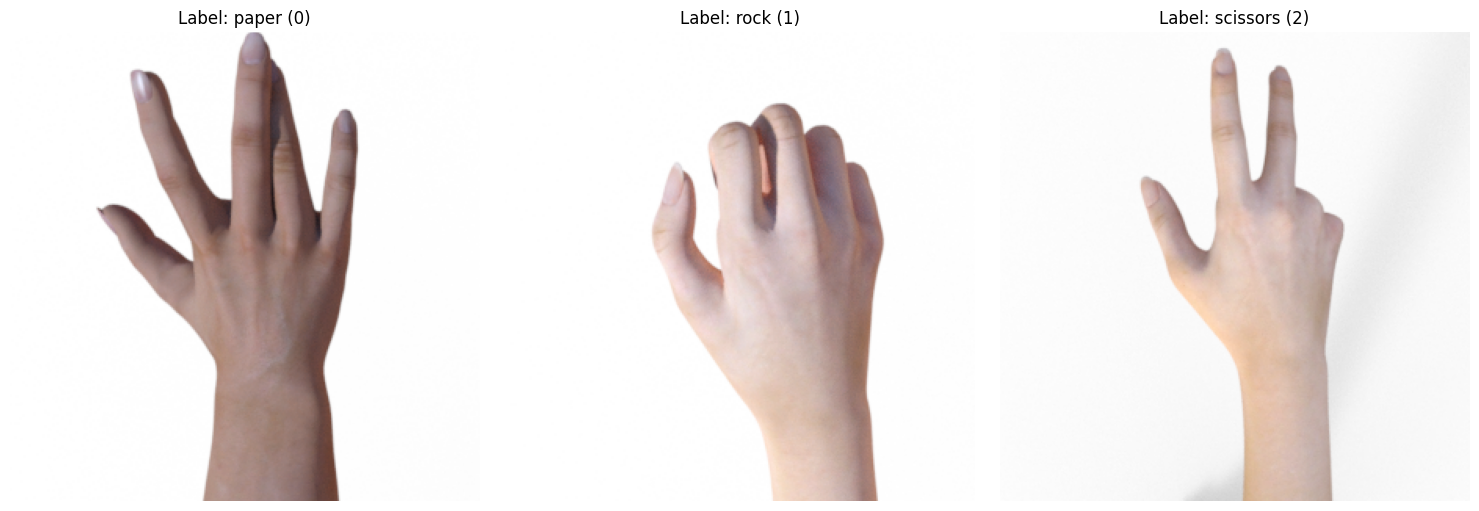

In [210]:
# example images (before data modification)

paper_img = Image.open('/content/Rock-Paper-Scissors/train/paper/paper01-000.png')
rock_img = Image.open('/content/Rock-Paper-Scissors/train/rock/rock01-000.png')
scissors_img = Image.open('/content/Rock-Paper-Scissors/train/scissors/scissors01-000.png')

labels = ['paper', 'rock', 'scissors']
images = [paper_img, rock_img, scissors_img]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
  axs[i].imshow(images[i])
  axs[i].set_title(f"Label: {labels[i]} ({i})")
  axs[i].axis('off')
    
plt.tight_layout()
plt.show()

Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32]) torch.int64


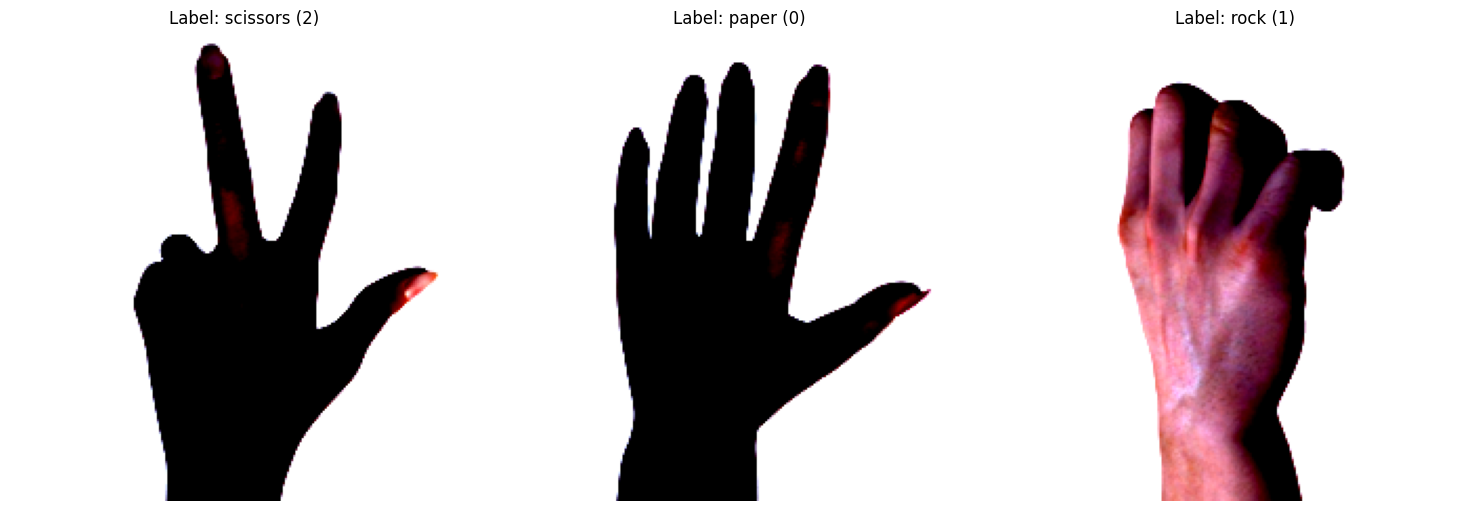

In [224]:
# example images (after data modification)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    for i in range(3):
        image = X[i]
        label = y[i].item()

        image = image.permute(1, 2, 0)

        axs[i].imshow(image)
        axs[i].set_title(f"Label: {labels[label]} ({label})")
        axs[i].axis('off')

    break
    
plt.tight_layout()
plt.show()

In [213]:
len(train_dataloader)

79

In [9]:
# create device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [99]:
# set random seeds so its reproducible

np.random.seed(28)

torch.manual_seed(28)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(28)

--------------




In [151]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.bn1 = nn.BatchNorm2d(5) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 9, 5)
        self.bn2 = nn.BatchNorm2d(9) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9*53*53, 220)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(220, 130)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(130, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x)))) 
        x = self.pool2(F.relu(self.bn2(self.conv2(x)))) 
        x = x.view(-1, 9*53*53)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


cnn = CNN().to(device)
print(cnn)

Using cpu device
CNN(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 9, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25281, out_features=220, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=220, out_features=130, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=130, out_features=3, bias=True)
)


In [152]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 9, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25281, out_features=220, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=220, out_features=130, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=130, out_features=3, bias=True)
)


--------------




In [159]:
# use cross entropy loss and adam

loss_fn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=1e-4, weight_decay = 1e-2)

In [160]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # forward propagation
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 30 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d} /{size:>5d}]")

In [161]:
def test(dataloader, model, loss_fn, mode='test'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    y_true = [] # true labels
    y_pred = [] # predicted labels
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.argmax(1).tolist())

    test_loss /= num_batches
    correct /= size
    print(f"{mode} error: \n accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return y_true, y_pred

In [162]:
epochs = 8

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn, loss_fn, optimizer_cnn)
    _, _ = test(train_dataloader, cnn, loss_fn, mode='train')
    y_true, y_pred = test(test_dataloader, cnn, loss_fn)

Epoch 1
-------------------------------
loss: 0.005313  [   32 / 2520]
loss: 0.004786  [  992 / 2520]
loss: 0.136592  [ 1952 / 2520]
train error: 
 accuracy: 99.9%, avg loss: 0.004274 

test error: 
 accuracy: 73.7%, avg loss: 0.749394 

Epoch 2
-------------------------------
loss: 0.003794  [   32 / 2520]
loss: 0.010738  [  992 / 2520]
loss: 0.002775  [ 1952 / 2520]
train error: 
 accuracy: 100.0%, avg loss: 0.002555 

test error: 
 accuracy: 81.7%, avg loss: 0.546294 

Epoch 3
-------------------------------
loss: 0.026381  [   32 / 2520]
loss: 0.011724  [  992 / 2520]
loss: 0.014369  [ 1952 / 2520]
train error: 
 accuracy: 100.0%, avg loss: 0.001406 

test error: 
 accuracy: 81.7%, avg loss: 0.610040 

Epoch 4
-------------------------------
loss: 0.001233  [   32 / 2520]
loss: 0.041567  [  992 / 2520]
loss: 0.004003  [ 1952 / 2520]
train error: 
 accuracy: 100.0%, avg loss: 0.001325 

test error: 
 accuracy: 74.7%, avg loss: 0.803411 

Epoch 5
-------------------------------
loss:

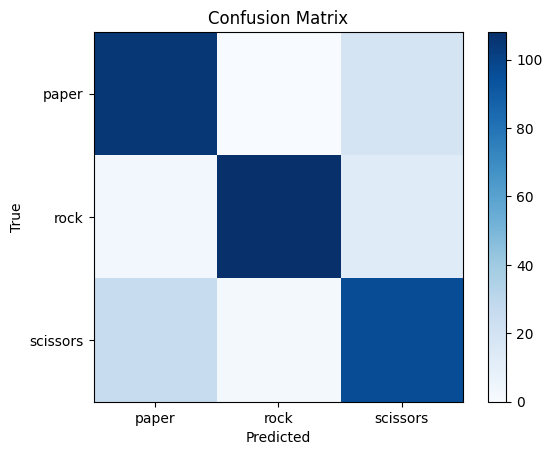

In [183]:
from sklearn.metrics import confusion_matrix

# create confusion matrix

cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.title('Confusion Matrix')
plt.show()

--------------




In [170]:
# save the model

torch.save(cnn.state_dict(), "model.pth")
print("pytorch model saved to model.pth")

pytorch model saved to model.pth
